# Redes neuronales

## Trabajar con R desde Python

Python ofrece una librería denominada rpy2, que permite leer los códigos de R y usar todas sus funcionalidades. En los notebooks de jupyter o google colab el trabajo con ambos se hace aún más fácil utilizando la sentencia mágica "%R"

In [ ]:
%load_ext rpy2.ipython
import rpy2.robjects as ro

En una misma celda se pueden combinar sentencias de R y de python. Para hacerlo hay que colocar la sentencia mágica "%R" antes de la línea de R que se quiere trabajar.

In [ ]:
a = [5,3, 2]  #esto es python
%R b <- c(3,4,2) #esto es R

print("Esta es una lista creada en python: ", a)
print("Este es un vector creado en R: ", ro.r['b'])

Esta es una lista creada en python:  [5, 3, 2]
Este es un vector creado en R:  [1] 3 4 2



Cuándo utilizamos "%%R" al principio de la celda, toda la celda es interpretada con R y por lo tanto podemos utilizar todas las funcionalidades que este software ofrece, desde crear objetos sencillos como vectores y matrices hasta instalar y utilizar librerías más complejas. 


In [ ]:
%%R 
z <- c(5,4,3)
print(z)

[1] 5 4 3


Esto permite mostrar los objetos de R y trabajarlos en ese entorno, pero aún no deja que python los pueda manipular. Para eso es necesario utilizar los objetos que ofrece la librería en "rpy2.robjects". 

In [ ]:
p = ro.r['z']
type(p)

rpy2.robjects.vectors.FloatVector

Por supuesto el objeto obtenido es un vector de rpy2.robjects, pero ahora se puede transformar fácilmente en una lista de python con el comando "list"

In [ ]:
p = list(p)
print(p)
print(type(p))

[5.0, 4.0, 3.0]
<class 'list'>


Para convertir un objeto de python en un objeto de R, se utiliza el método "rpy2.robjects.r.assing".

In [ ]:
p_en_R = ro.r.assign("p_en_r", p)
%R print(as.numeric(p_en_r))

[1] 5 4 3


array([5., 4., 3.])

## lectura de datos e instalación

In [ ]:
%%R
packages <- c( "numDeriv",
              "neuralnet")
not_installed <- !packages %in% installed.packages()
if (any(not_installed)) install.packages(packages[not_installed])

## Descenso del gradiente

Los algoritmos de deep learning tratan de optimizar alguna función. Por optimización nos referimos a obtener el mínimo o máximo de alguna función objetivo.



Esta función tiene solución analítica bien conocida, pero en la práctica podemos enfrentarnos a otro tipo de funciones en las cuales no es posible encontrar una solución analítica, pero si podemos encontrar soluciones numéricas.

Una forma sencilla de hacerlo es con la técnica del descenso del gradiente. Si tenemos una función de una sola variable, el signo de la derivada indica la dirección en que la función crece. Por lo tanto como el objetivo es minimizarla, lo lógico sería dar pequeños pasos en la dirección contraria al signo de la derivada hasta alcanzar aquel punto en que la derivada es cero o muy cercana a el.

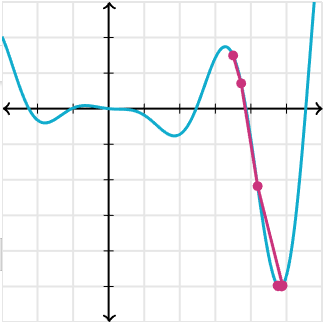

Para funciones de múltiples variables, usamos el vector gradiente que contiene a todas las derivadas parciales de la función $\nabla_xf\left(x\right)$. EL gradiente refleja la dirección en la que la función crece más rápido, por lo tanto podemos extender el concepto anterior y decir que para buscár el mínimo necesitamos ir en la dirección contraria a la que marca el vector gradiente.

\begin{equation}
x_{n+1} = x_n - η∇f\left(x_n\right)
\end{equation}

**Limitaciones**

- La posibilidad de llegar a mínimos locales
- EL tamaño de los pasos puede hacer que  nunca converga
- La función debe ser diferenciable en todos los puntos

**Ejemplo con mínimos cuadrados**

Pongamos en práctica el descenso del gradiente para calcular los mínimos cuadrados.

En este caso la función de pérdida es el error cuadrático medio. 

\begin{equation}
ECM\left(\beta\right) = \frac{1}{N}\sum_{i=1}^{N}\left(y_i-\sum_{j=0}^{p}x_{ij}\beta_j\right)^2
\end{equation}

La idea es minimizar la función pero con respecto al parámetro $\beta$.

In [ ]:
%%R
library(numDeriv) 

set.seed(1)

x <- runif(30, min = 0, max = 5) #generamos valores de x
y <- 2*x #generamos valores de y en función de x

fc <- function(beta) mean((y-beta*x)^2)  #definimos la función de costo en función del parámetro beta
beta_0 <- runif(1) #definimos aleatoriamente los parámetros iniciales
eta <- 0.05 # definimos la tasa de aprendizaje
betas <- c()
deriv <- c()
costo <- c()
i <- 1
betas <- c(betas,beta_0)
deriv <- c(deriv,grad(fc, x = beta_0))
costo <- c(costo,fc(beta_0))
while(i < 10){
    der <- grad(fc, x = betas[i])
    beta <- betas[i]- eta * der 
    cost <- fc(beta)
    betas <- c(betas,beta)
    deriv <-  c(deriv,der)
    costo <- c(costo,cost)
    i <- i+1
}

rdo <- cbind(costo,deriv,betas)
print(rdo)

             costo         deriv     betas
 [1,] 1.981092e+01 -2.610273e+01 0.4820801
 [2,] 3.892989e-01 -2.610273e+01 1.7872164
 [3,] 7.650003e-03 -3.659107e+00 1.9701718
 [4,] 1.503281e-04 -5.129373e-01 1.9958187
 [5,] 2.954055e-06 -7.190408e-02 1.9994139
 [6,] 5.804929e-08 -1.007959e-02 1.9999178
 [7,] 1.140710e-09 -1.412967e-03 1.9999885
 [8,] 2.241578e-11 -1.980711e-04 1.9999984
 [9,] 4.404862e-13 -2.776582e-05 1.9999998
[10,] 8.655870e-15 -3.892240e-06 2.0000000


## Perceptrón 

Sí tomamos la regresión lineal bien y le agregamos una función escalón que nos devuelva 1 en caso de que la función sea mayor a un umbral o 0 en otro caso, tenemos una red neuronal de una sola capa o perceptrón.


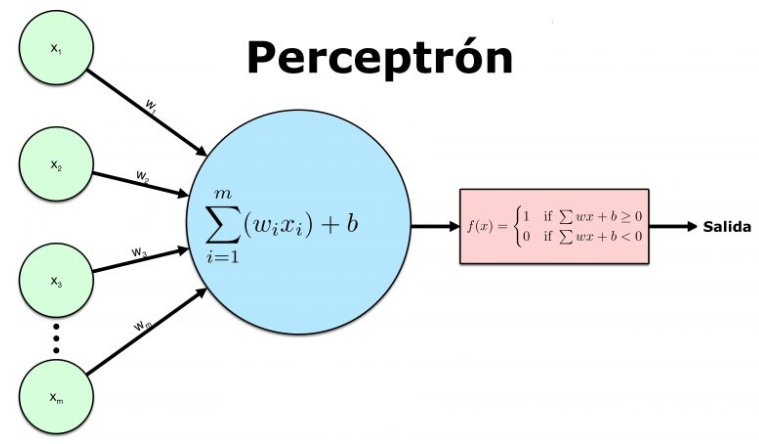

La red neuronal de una sola capa no puede predecir cuando en la respuesta tenemos un problema xor. Solo aplica una separación lineal y cuando tenemos problemas que no son separables linealmente tiene problemas.

### Función de activación 

Agregando otra neurona a nuestra red neuronal, podemos resolver el problema xor. Pero para que pueda funcionar correctamente y no colapsen, es necesario agregar una no linealidad para que las neuronas no colapsen entre sí. Esto se hace mediante una función que se conoce como función de activación.

Las funciones de activación más conocidas son:

- logística: $\sigma(z) = \frac{1}{1+exp(-z)}$

- tangente hiperbólica: $tanh(z) = \frac{e^z-e^{-z}}{e^z+e^{-z}}$

- *Rectified Linear Unit function* : $ReLU(z)= max(0,z)$





In [ ]:
%%R

set.seed(5)

x1 <- runif(30, min = 0, max = 5) 
x2 <- runif(30, min = 0, max = 5) 
y <- 2*x1-3*x2 + runif(30, min =-0.5, max = 0.5)
y_ <- c()
for (i in 1:length(y)){
    if(y[i] > 0) {r = 1} else{r = 0}
    y_[i] <- r
}


X <- cbind(x1,x2)

fc <- function(beta) mean((y- X %*% beta)^2)  #definimos la función de costo en función del parámetro beta
 
#eta <- 0.05 # definimos la tasa de aprendizaje
opt_grad <- function(fc,pasos = 10, eta = 0.05){
  beta <- runif(2)
  i <- 1
  while(i < pasos){
      gr <- grad(fc, x = beta)
      beta <- beta- eta * gr
      cost <- fc(beta)
      i <- i+1
  }
  return(beta)
}
lineal <- function(beta) X %*% beta
neurona <- function(f = lineal, umbral = 0.5,...) {
    beta <- opt_grad(fc = fc, pasos = 20, eta = 0.05)
    rdo <- X %*% beta
    rdo_ <- c() 
    for (i in 1:length(rdo)){
        if(rdo[i] > umbral){y_ = 1}else{y_ = 0}
        rdo_[i] <- y_}
    print(paste('Los parámetros son: ', beta))
    return (rdo_)
}
neurona(lineal)

[1] "Los parámetros son:  2.06240803597287" 
[2] "Los parámetros son:  -3.04459135815346"
 [1] 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1


In [ ]:
%%R
set.seed(5)
#creamos otra función con la función de activación para aplicar y tenemos la nurona construida
fc_relu <- function(beta) max(0, fc(beta))

neurona(fc = fc_relu)

[1] "Los parámetros son:  2.06157179435168"
[2] "Los parámetros son:  -3.043701380774" 
 [1] 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1


## Redes neuronales profundas

Se pueden ir agregando neuronas y capas que permiten tener redes cada vez mas complejas y nos van a permitir poder predecir otro tipo de resultados. Cuándo se agregan capas, el funcionamiento sigue siendo el mismo que el que se usa en la red simple.

1.   Iniciar el entrenamiento con pesos aleatorios
2.   Calcular el vector gradiente 
3.   Actualizar los pesos en la dirección contraria al gradiente
4.   Repetir hasta llegar a números cercanos a cero.

Mientras más compleja volvemos la red neuronal, más tedioso se vuelve calcular el gradiente, incluso computacionalmente suele ser complicado de mantener todos los dataos numéricos. El algoritmo que se utiliza para resolver las derivadas parciales, es el de la propagación hacia atrás (*backpropagation*). Este empieza desde la última capa y va determinando los pesos capa tras capa.


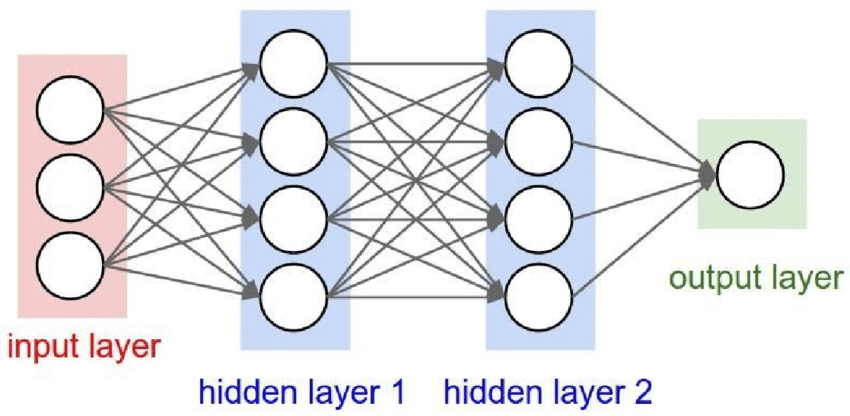

Tensor flow es una librería que se puede utilizar en python para ejecutar redes neuronales. En esta página https://playground.tensorflow.org/ se puede jugar armando redes neuronales y viendo el resultado que se obtiene al modificar los parámetros.

### Redes neuronales con R

Para trabajar con redes más complejas en R se puede utilizar la librería "neuralnet". 

Vamos a trabajar con la base de datos de los vinos


In [ ]:
%R vinos <- read.csv("WineQT.csv")

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,Id
1,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
2,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
3,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,2
4,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,3
5,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1592
1140,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1593
1141,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1594
1142,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1595


La variable de salida va ser "quality" que indica la categoría del vino de acuerdo a las características

In [ ]:
%%R
library(neuralnet)

set.seed(10)
variables <- names(vinos)[1:(length(names(vinos))-2)]
#convertimos las categorías en solo 2 
y <- vinos$quality > 5
vinos.modif <- cbind(scale(vinos[,variables]), y)
vinos.modif <- as.data.frame(vinos.modif)

muestra <- sample(nrow(vinos.modif), round(nrow(vinos.modif)*0.8), replace = FALSE)
vinos.train <- vinos.modif[muestra,]
vinos.test <- vinos.modif[-muestra,]

print(dim(vinos.test))
print(dim(vinos.train))

[1] 229  12
[1] 914  12


In [ ]:
%R head(vinos.test)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,y
24,-0.006358,0.688411,-0.754319,-0.171214,-0.083200,-0.060045,2.046398,-0.067744,-0.900110,0.013452,-0.593341,0.0
28,-0.120801,-0.842487,0.059161,-0.318716,-0.442856,-0.255157,-0.485469,0.036149,-0.517125,0.424253,-0.685746,1.0
30,0.279750,0.437900,0.160846,0.197540,0.022581,0.135068,0.002602,0.451719,-0.325632,-0.866836,-1.055365,0.0
38,0.165307,-0.842487,0.465901,0.345041,-0.125512,1.403301,2.229425,0.140041,-0.708617,-0.573407,-0.962960,0.0
41,-0.292465,0.326562,-0.449264,-0.171214,-0.231294,0.135068,0.246637,0.399772,0.759492,-0.397349,-0.408532,0.0
45,-0.750237,1.133763,-1.110217,-0.392467,-0.125512,-0.255157,0.246637,-0.067744,0.504169,-0.514721,-0.593341,0.0


In [ ]:
%%R
rn1 <- neuralnet(y ~., data= vinos.train, hidden = 4,threshold = 0.0001, linear.output = FALSE)


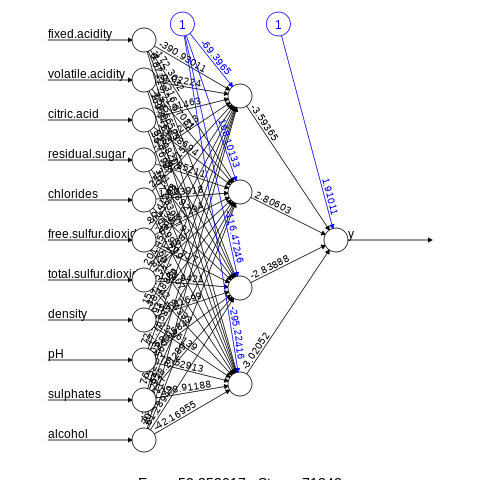

In [ ]:
%R plot(rn1, rep= 'best' )

In [ ]:
%R str(rn1)

List of 9
 $ call         : language neuralnet(formula = (y == 1) + (y == 2) + (y == 3) + (y == 4) + (y == 5) +      (y == 6) ~ ., data = vinos.train,| __truncated__
 $ response     : logi [1:914, 1:6] FALSE FALSE FALSE FALSE FALSE FALSE ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:914] "491" "368" "439" "344" ...
  .. ..$ : chr [1:6] "y == 1" "y == 2" "y == 3" "y == 4" ...
 $ covariate    : num [1:914, 1:11] 0.16531 2.39694 -0.00636 1.08085 -0.80746 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:914] "491" "368" "439" "344" ...
  .. ..$ : chr [1:11] "fixed.acidity" "volatile.acidity" "citric.acid" "residual.sugar" ...
 $ model.list   :List of 2
  ..$ response : chr [1:6] "y == 1" "y == 2" "y == 3" "y == 4" ...
  ..$ variables: chr [1:11] "fixed.acidity" "volatile.acidity" "citric.acid" "residual.sugar" ...
 $ err.fct      :function (x, y)  
  ..- attr(*, "type")= chr "sse"
 $ act.fct      :function (x)  
  ..- attr(*, "type")= chr "logistic"
 $ linear.output: l

Podemos calcular el f1 score de la predicción de esta red sobre la base de test

In [ ]:
%%R source("funciones.r" , local = TRUE)

y_pred_train <- clasif(predict(rn1, vinos.train),0.5)
y_pred <- clasif(predict(rn1, vinos.test),0.5)

f1_rn1 <-f1_score(y_pred, as.data.frame(vinos.test)$y)
f1_rn1_train <- f1_score(y_pred_train, as.data.frame(vinos.train)$y)
rn1_rdo <- c('f1 train' = f1_rn1_train, 'f1 test' = f1_rn1)
rn1_rdo

 f1 train   f1 test 
0.8740000 0.7372881 


## Aplicación de redes neuronales

In [ ]:
%R w <- desc_grad(model.matrix(linear,X.train), y.train, eta = 0.001)

array([-1.88235422e+86,  3.13736442e+88,  1.41769180e+88, -1.16113637e+86,
        4.52326740e+88, -3.64667717e+87, -1.56273559e+87, -2.58216129e+88,
       -1.49612067e+87, -1.95412203e+88,  8.16692649e+88, -4.37793729e+88,
       -5.38824295e+88, -5.88237656e+88, -7.76496875e+88,  5.60905944e+88,
        7.36126838e+88,  7.62931433e+88, -1.06642946e+89,  1.01250287e+89,
        2.57243393e+88,  2.04381261e+87, -1.13454571e+87,  1.01321419e+87,
        4.06598811e+87,  9.95134589e+86, -1.24397261e+87,  7.92063468e+86,
       -5.29310254e+86,  8.45880336e+86,  6.73377952e+86, -3.07132788e+87,
       -1.11441651e+87, -1.07711985e+87])

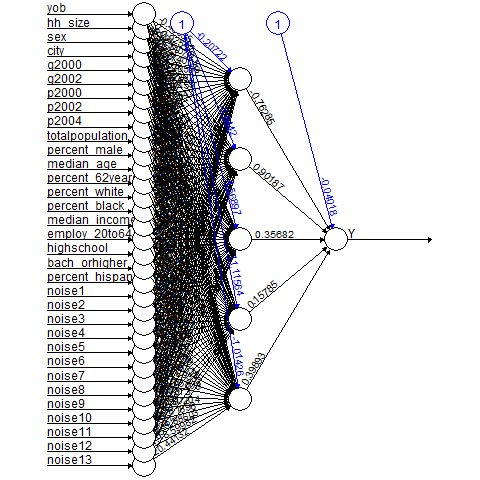

In [ ]:
%%R 

rnv <- neuralnet(linear, X.train, hidden = 5)
plot(rnv, rep = 'best')

In [ ]:
%R source("funciones.r", local = TRUE)

In [ ]:
%R mean((predict(rnv, X.test)-y.test)^2)

array([0.21080086])

In [ ]:
%R mean((predict(rnv, X.train)-y.train)^2)

array([0.19363769])

In [ ]:
%R mean((predict(mco, X.test)-y.test)^2)

array([0.20487872])

In [ ]:
%%R

mco <- lm(linear, X.train)
summary(mco)


Call:
lm(formula = linear, data = X.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7654 -0.3411 -0.2170  0.5382  1.0020 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.320276   0.003349  95.642  < 2e-16 ***
yob                      -0.032381   0.003714  -8.718  < 2e-16 ***
hh_size                   0.009691   0.003540   2.738  0.00620 ** 
sex                      -0.008945   0.003356  -2.665  0.00770 ** 
city                      0.042226   0.003575  11.811  < 2e-16 ***
g2000                    -0.009015   0.003703  -2.434  0.01492 *  
g2002                     0.029086   0.003681   7.902 2.91e-15 ***
p2000                     0.037072   0.003449  10.750  < 2e-16 ***
p2002                     0.058156   0.003485  16.688  < 2e-16 ***
p2004                     0.079698   0.003441  23.159  < 2e-16 ***
totalpopulation_estimate  0.009131   0.004324   2.112  0.03474 *  
percent_male             -0.002708   0.0040

## Uso de Keras

In [ ]:
import pandas as pd
from tensorflow import keras 
from tensorflow.keras import layers

In [ ]:
from rpy2.robjects.packages import importr 
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

In [ ]:
%%R
y.test <- vinos.test$y
y.train <- vinos.train$y



In [ ]:
# Leemos los objetos de R y los nombramos en una variable intepretable por python
X_train = ro.r['vinos.train']
X_test = ro.r['vinos.test']
y_test = ro.r['y.test']
y_train = ro.r['y.train']

# Convertimos los objetos r2py en dataframe de pandas
with localconverter(ro.default_converter+pandas2ri.converter):
    X_train = ro.conversion.rpy2py(X_train)
    X_test = ro.conversion.rpy2py(X_test)
    y_train = ro.conversion.rpy2py(y_train)
    y_test = ro.conversion.rpy2py(y_test)

In [ ]:
X_train.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,y
491,0.165307,-0.230128,1.228538,-0.392467,7.088772,0.037512,0.490673,0.607557,-1.793742,3.006432,-1.332579,0.0
368,2.396945,0.382231,1.126853,1.303802,0.276457,-1.035608,-0.973539,2.217891,-0.389463,0.482939,1.347158,1.0
439,-0.006358,0.048217,-0.144209,0.640045,-0.231294,0.037512,2.015894,0.451719,-0.261801,-0.279977,-0.962960,0.0
344,1.080850,0.632742,0.465901,-0.539968,-0.717888,-1.035608,-0.973539,0.763396,-0.900110,-1.395009,-0.408532,1.0
143,-0.807459,3.110012,-1.059374,-0.318716,-0.548637,-0.352714,-0.454964,-1.002776,1.270139,-1.336323,0.885134,0.0


In [ ]:
y_train = X_train[['y']]
y_test = X_test[['y']]

X_train = X_train.drop(['y'], axis = 1)
X_test = X_test.drop(['y'], axis = 1)
                 

### Creando una red neuronal simple en Keras

In [ ]:
# Creamos una red neuronal con keras
col = X_train.shape[1]
model = keras.Sequential([
    layers.Dense(1, # Indicamos el tamaño del output de la capa
                 activation = 'sigmoid', # indicamos la función de activación 
                 input_shape = [col] # la cantidad de variables de la base de datos
                )
    ])

In [ ]:
# compilamos el modelo, en dónde le definimos la función de pérdida y el optimizador

model.compile(optimizer = 'sgd', #elegimos el descenso del gradiente estocástico como optimizador
              loss = 'binary_crossentropy', #elegimos como función de pérdida los mínimos cuadrados
               metrics=['binary_accuracy']
             )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 12        
                                                                 
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs = 50)

Epoch 1/50
29/29 [==============================] - 1s 1ms/step - loss: 0.9306 - binary_accuracy: 0.4464
Epoch 2/50
29/29 [==============================] - 0s 1ms/step - loss: 0.8695 - binary_accuracy: 0.4716
Epoch 3/50
29/29 [==============================] - 0s 1ms/step - loss: 0.8170 - binary_accuracy: 0.4967
Epoch 4/50
29/29 [==============================] - 0s 1ms/step - loss: 0.7725 - binary_accuracy: 0.5328
Epoch 5/50
29/29 [==============================] - 0s 1ms/step - loss: 0.7349 - binary_accuracy: 0.5547
Epoch 6/50
29/29 [==============================] - 0s 1ms/step - loss: 0.7032 - binary_accuracy: 0.5733
Epoch 7/50
29/29 [==============================] - 0s 2ms/step - loss: 0.6771 - binary_accuracy: 0.5952
Epoch 8/50
29/29 [==============================] - 0s 1ms/step - loss: 0.6555 - binary_accuracy: 0.6138
Epoch 9/50
29/29 [==============================] - 0s 1ms/step - loss: 0.6376 - binary_accuracy: 0.6302
Epoch 10/50
29/29 [==============================] - 0s

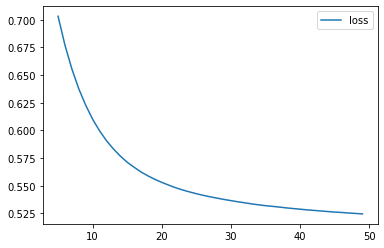

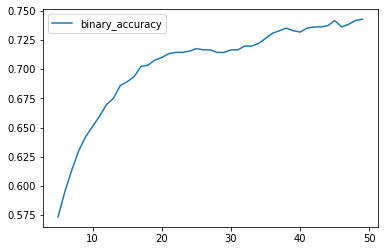

In [ ]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss']].plot()
history_df.loc[5:, ['binary_accuracy']].plot()



In [ ]:
from sklearn.metrics import f1_score
predic_train = model.predict(X_train) >0.5
predic_test = model.predict(X_test) > 0.5

f1_score(y_train, predic_train),f1_score(y_test, predic_test)

(0.759545923632611, 0.7423580786026202)

### Agregando regularizadores

In [ ]:
model2 = keras.Sequential([
    layers.Dense(1, # Indicamos el tamaño del output de la capa
                 activation = 'sigmoid', # indicamos la función de activación 
                 input_shape = [col], # la cantidad de variables de la base de datos
                 kernel_regularizer = keras.regularizers.l1(0.4)
                )
    ])

In [ ]:
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
history = model2.fit(X_train, y_train, epochs = 50, validation_split = 0.8)

Epoch 1/50
6/6 [==============================] - 1s 50ms/step - loss: 2.3975 - binary_accuracy: 0.4066 - val_loss: 2.4700 - val_binary_accuracy: 0.3169
Epoch 2/50
6/6 [==============================] - 0s 9ms/step - loss: 2.3685 - binary_accuracy: 0.4066 - val_loss: 2.4404 - val_binary_accuracy: 0.3142
Epoch 3/50
6/6 [==============================] - 0s 17ms/step - loss: 2.3398 - binary_accuracy: 0.4066 - val_loss: 2.4109 - val_binary_accuracy: 0.3128
Epoch 4/50
6/6 [==============================] - 0s 10ms/step - loss: 2.3106 - binary_accuracy: 0.4066 - val_loss: 2.3815 - val_binary_accuracy: 0.3142
Epoch 5/50
6/6 [==============================] - 0s 19ms/step - loss: 2.2820 - binary_accuracy: 0.4011 - val_loss: 2.3520 - val_binary_accuracy: 0.3128
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 2.2530 - binary_accuracy: 0.3956 - val_loss: 2.3226 - val_binary_accuracy: 0.3074
Epoch 7/50
6/6 [==============================] - 0s 11ms/step - loss: 2.2241 - bin

Best Validation Loss: 1.2976
Best Validation Accuracy: 0.3169


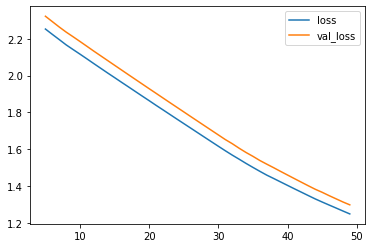

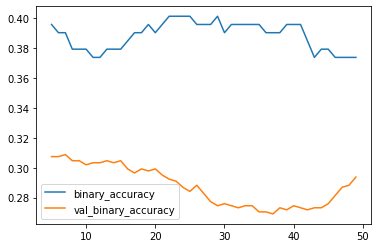

In [ ]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Mejor valor de pérdida de la validación: {:0.4f}" +\
      "\nMejor valor de accuracy de la validación: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [ ]:
predic_train = model2.predict(X_train) >0.5
predic_test = model2.predict(X_test) > 0.5

f1_score(y_train, predic_train),f1_score(y_test, predic_test)

(0.4151992585727525, 0.4421052631578948)

### Elaborando modelos más complejos

In [ ]:
col_ = X_train.shape[1]

model3 = keras.Sequential([
    layers.Dense(520, activation = 'relu', input_shape = [col_]),
    layers.Dense(520, activation = 'relu'),
    layers.Dense(520, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
    ])

In [ ]:
model3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
history = model3.fit(X_train, y_train, epochs = 50, validation_split = 0.7, verbose = False)

Best Validation Loss: 0.5444
Best Validation Accuracy: 0.7531


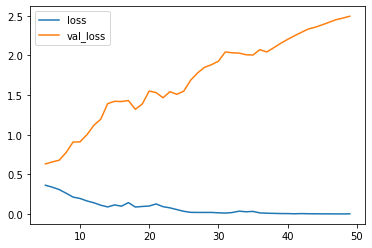

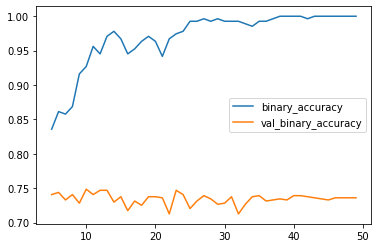

In [ ]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [ ]:
predic_train = model3.predict(X_train) >0.5
predic_test = model3.predict(X_test) > 0.5

f1_score(y_train, predic_train),f1_score(y_test, predic_test)

(0.8311688311688311, 0.7479674796747968)